In [ ]:
#pip install -r ..\requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
train = joblib.load(r"..\assets\combined\train_raw.pkl")
test = joblib.load(r"..\assets\combined\test_raw.pkl")
print(train.shape, test.shape)

(2643279, 50) (694638, 50)


In [4]:
for var in ['game_genres', 'game_tags', 'game_esrb_rating', 'user_country_code', 'game_available_platform', 'game_available_parent_platforms']:
    print(var + ": " + str(len(dict(train[var].explode().value_counts()))))

game_genres: 19
game_tags: 2501
game_esrb_rating: 7
user_country_code: 222
game_available_platform: 47
game_available_parent_platforms: 14


In [5]:
esrb_categories = list(train['game_esrb_rating'].unique())
if "Unknown" not in esrb_categories:
    esrb_categories.append("Unknown")

# Create the OneHotEncoder. Using handle_unknown='ignore' means that any unseen value will be all zeros.
encoder = OneHotEncoder(categories=[esrb_categories], handle_unknown='ignore', sparse_output=False)
encoder.fit(train[['game_esrb_rating']])

# In test data, replace any unseen value with "Unknown"
test['game_esrb_rating'] = test['game_esrb_rating'].apply(
    lambda x: x if x in esrb_categories else "Unknown"
)

# Transform both training and test data
train_esrb_encoded = encoder.transform(train[['game_esrb_rating']])
test_esrb_encoded = encoder.transform(test[['game_esrb_rating']])

esrb_columns = encoder.get_feature_names_out(['game_esrb_rating'])
train_esrb_df = pd.DataFrame(train_esrb_encoded, columns=esrb_columns)
test_esrb_df = pd.DataFrame(test_esrb_encoded, columns=esrb_columns)

In [6]:
def process_multilabel(train_series, test_series, prefix):
    """
    For multi-label columns:
    - For each list in train or test data, replace any label not in the original known set with "Unknown".
      If multiple unknown labels occur, "Unknown" is added only once.
    - Return the encoded arrays and the final classes.
    """
    # Get original known labels from training only
    orig_known_labels = set()
    for labels in train_series:
        orig_known_labels.update(labels)
    # Define allowed labels (sorted list) as the union of training labels and "Unknown"
    allowed_labels = sorted(list(orig_known_labels) + ["Unknown"])
    
    def replace_unknown(labels):
        # Keep labels that are known (from training)
        new_labels = [label for label in labels if label in orig_known_labels]
        # If there is any label that is not known, add "Unknown"
        if any(label not in orig_known_labels for label in labels):
            if "Unknown" not in new_labels:
                new_labels.append("Unknown")
        return new_labels
    
    # Process both training and test series
    train_processed = train_series.apply(replace_unknown)
    test_processed = test_series.apply(replace_unknown)
    
    mlb = MultiLabelBinarizer(classes=allowed_labels)
    mlb.fit(train_processed)  # Fit on training processed lists
    train_encoded = mlb.transform(train_processed)
    test_encoded = mlb.transform(test_processed)

    prefixed_columns = [f"{prefix}_{label}" if prefix else label for label in mlb.classes_]
    
    return train_encoded, test_encoded, prefixed_columns

# Process the genres column
train_genres_encoded, test_genres_encoded, genres_classes = process_multilabel(
    train['game_genres'], test['game_genres'], "game_genres"
)

# Process the available_parent_platforms column
train_platforms_encoded, test_platforms_encoded, platforms_classes = process_multilabel(
    train['game_available_parent_platforms'], test['game_available_parent_platforms'], "game_platforms"
)

train_genres_df = pd.DataFrame(train_genres_encoded, columns=genres_classes)
test_genres_df = pd.DataFrame(test_genres_encoded, columns=genres_classes)

train_platforms_df = pd.DataFrame(train_platforms_encoded, columns=platforms_classes)
test_platforms_df = pd.DataFrame(test_platforms_encoded, columns=platforms_classes)

In [7]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train_combined = pd.concat([train, train_esrb_df, train_genres_df, train_platforms_df], axis=1)
test_combined = pd.concat([test, test_esrb_df, test_genres_df, test_platforms_df], axis=1)

In [8]:
train_combined[['game_esrb_rating'] + esrb_columns.tolist()].sample(5)

,game_esrb_rating,game_esrb_rating_Rating Pending,game_esrb_rating_Missing,game_esrb_rating_Mature,game_esrb_rating_Everyone 10+,game_esrb_rating_Teen,game_esrb_rating_Everyone,game_esrb_rating_Adults Only,game_esrb_rating_Unknown
2103641,Mature,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1914987,Missing,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2586973,Missing,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1445575,Everyone 10+,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
262344,Mature,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_combined[['game_genres'] + genres_classes].sample(5)

,game_genres,game_genres_Action,game_genres_Adventure,game_genres_Arcade,game_genres_Board Games,game_genres_Card,game_genres_Casual,game_genres_Educational,game_genres_Family,game_genres_Fighting,...,game_genres_Massively Multiplayer,game_genres_Platformer,game_genres_Puzzle,game_genres_RPG,game_genres_Racing,game_genres_Shooter,game_genres_Simulation,game_genres_Sports,game_genres_Strategy,game_genres_Unknown
2442347,"[Strategy, Simulation, Indie]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2592360,"[Adventure, RPG, Strategy, Indie]",0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
433233,"[Action, Shooter, RPG]",1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
640612,"[Action, Shooter]",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
809886,"[Action, Indie]",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train_combined[['game_available_parent_platforms'] + platforms_classes].sample(5)

,game_available_parent_platforms,game_platforms_3DO,game_platforms_Android,game_platforms_Apple Macintosh,game_platforms_Atari,game_platforms_Commodore / Amiga,game_platforms_Linux,game_platforms_Neo Geo,game_platforms_Nintendo,game_platforms_PC,game_platforms_PlayStation,game_platforms_SEGA,game_platforms_Unknown,game_platforms_Web,game_platforms_Xbox,game_platforms_iOS
569890,[PC],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
522993,"[PC, Apple Macintosh, Linux, Nintendo]",0,0,1,0,0,1,0,1,1,0,0,0,0,0,0
804888,"[PC, Linux]",0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
220850,"[PC, PlayStation, Xbox, Apple Macintosh, Ninte...",0,0,1,0,0,0,0,1,1,1,0,0,0,1,0
2623884,[PC],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [11]:
train_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2643279 entries, 0 to 2643278
Data columns (total 93 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   user_id                                object 
 1   app_id                                 int64  
 2   relevance_score                        float64
 3   user_country_code                      object 
 4   user_has_coordinates                   bool   
 5   user_latitude                          float64
 6   user_longitude                         float64
 7   user_account_age_months                float64
 8   game_name                              string 
 9   game_tba                               boolean
 10  game_RAWG_weighted_avg_rating          Float64
 11  game_RAWG_ratings_count                Int64  
 12  game_RAWG_reviews_with_text_count      Int64  
 13  game_RAWG_bookmark_count               Int64  
 14  game_metacritic_rating                 Int64  
 15

In [12]:
def derive_user_features_from_games(df):
    df['game_popularity'] = (df['game_estimate_owners_lower'] + df['game_estimate_owners_upper']) / 2

    numerical_preferences = df.groupby('user_id').agg(
        user_preference_game_popularity=('game_popularity', 'mean'),
        user_preference_game_duration=('game_avg_playtime_forever', 'mean'),
        user_preference_new_game=('game_released_year', 'mean'),
        user_preference_avg_spent=('game_initial_price', 'mean')
    )
    
    esrb_preferences = df.groupby('user_id')[esrb_columns.tolist()].mean().add_prefix("user_preference_")
    genres_preferences = df.groupby('user_id')[genres_classes].mean().add_prefix("user_preference_")
    platforms_preferences = df.groupby('user_id')[platforms_classes].mean().add_prefix("user_preference_")

    numerical_preferences.reset_index(inplace=True)
    esrb_preferences.reset_index(inplace=True)
    genres_preferences.reset_index(inplace=True)
    platforms_preferences.reset_index(inplace=True)

    df = pd.merge(df, numerical_preferences, on='user_id', how='left')
    df = pd.merge(df, esrb_preferences, on='user_id', how='left')
    df = pd.merge(df, genres_preferences, on='user_id', how='left')
    df = pd.merge(df, platforms_preferences, on='user_id', how='left')

    return df

In [13]:
from sklearn.preprocessing import MinMaxScaler

train_combined = derive_user_features_from_games(train_combined)
test_combined = derive_user_features_from_games(test_combined)

numerical_preference_cols = [
    'user_preference_game_popularity',
    'user_preference_game_duration',
    'user_preference_new_game',
    'user_preference_avg_spent'
]

scaler = MinMaxScaler()
# Scale numerical preference columns to [0, 1]
train_combined[numerical_preference_cols] = scaler.fit_transform(train_combined[numerical_preference_cols])
test_combined[numerical_preference_cols] = scaler.transform(test_combined[numerical_preference_cols])


In [14]:
user_preference_col = train_combined.filter(like="user_preference_").columns
train_combined[train_combined.filter(like="user_preference_").columns].sample(5)

,user_preference_game_popularity,user_preference_game_duration,user_preference_new_game,user_preference_avg_spent,user_preference_game_esrb_rating_Rating Pending,user_preference_game_esrb_rating_Missing,user_preference_game_esrb_rating_Mature,user_preference_game_esrb_rating_Everyone 10+,user_preference_game_esrb_rating_Teen,user_preference_game_esrb_rating_Everyone,...,user_preference_game_platforms_Linux,user_preference_game_platforms_Neo Geo,user_preference_game_platforms_Nintendo,user_preference_game_platforms_PC,user_preference_game_platforms_PlayStation,user_preference_game_platforms_SEGA,user_preference_game_platforms_Unknown,user_preference_game_platforms_Web,user_preference_game_platforms_Xbox,user_preference_game_platforms_iOS
483450,0.003972,0.010765,0.720328,0.443256,0.002285,0.643585,0.098946,0.080316,0.122847,0.033040,...,0.265905,0.001406,0.247803,0.998770,0.350967,0.004218,0.0,0.004042,0.296134,0.140773
1730203,0.022244,0.039017,0.706010,0.571712,0.004878,0.466667,0.263415,0.056911,0.152846,0.030894,...,0.326829,0.000000,0.295935,1.000000,0.528455,0.001626,0.0,0.008130,0.521951,0.130081
967575,0.003004,0.008718,0.636628,0.165317,0.000209,0.753650,0.059449,0.062578,0.081560,0.025866,...,0.257405,0.000209,0.090113,0.999583,0.161452,0.004172,0.0,0.004589,0.137881,0.122445
1442238,0.044287,0.062924,0.627180,0.464690,0.002625,0.459318,0.296588,0.041995,0.139108,0.031496,...,0.312336,0.000000,0.154856,1.000000,0.482940,0.007874,0.0,0.005249,0.488189,0.112861
2594382,0.021559,0.034228,0.615190,0.390949,0.001818,0.498182,0.192727,0.089091,0.160000,0.038182,...,0.372727,0.000000,0.269091,1.000000,0.494545,0.014545,0.0,0.010909,0.443636,0.198182


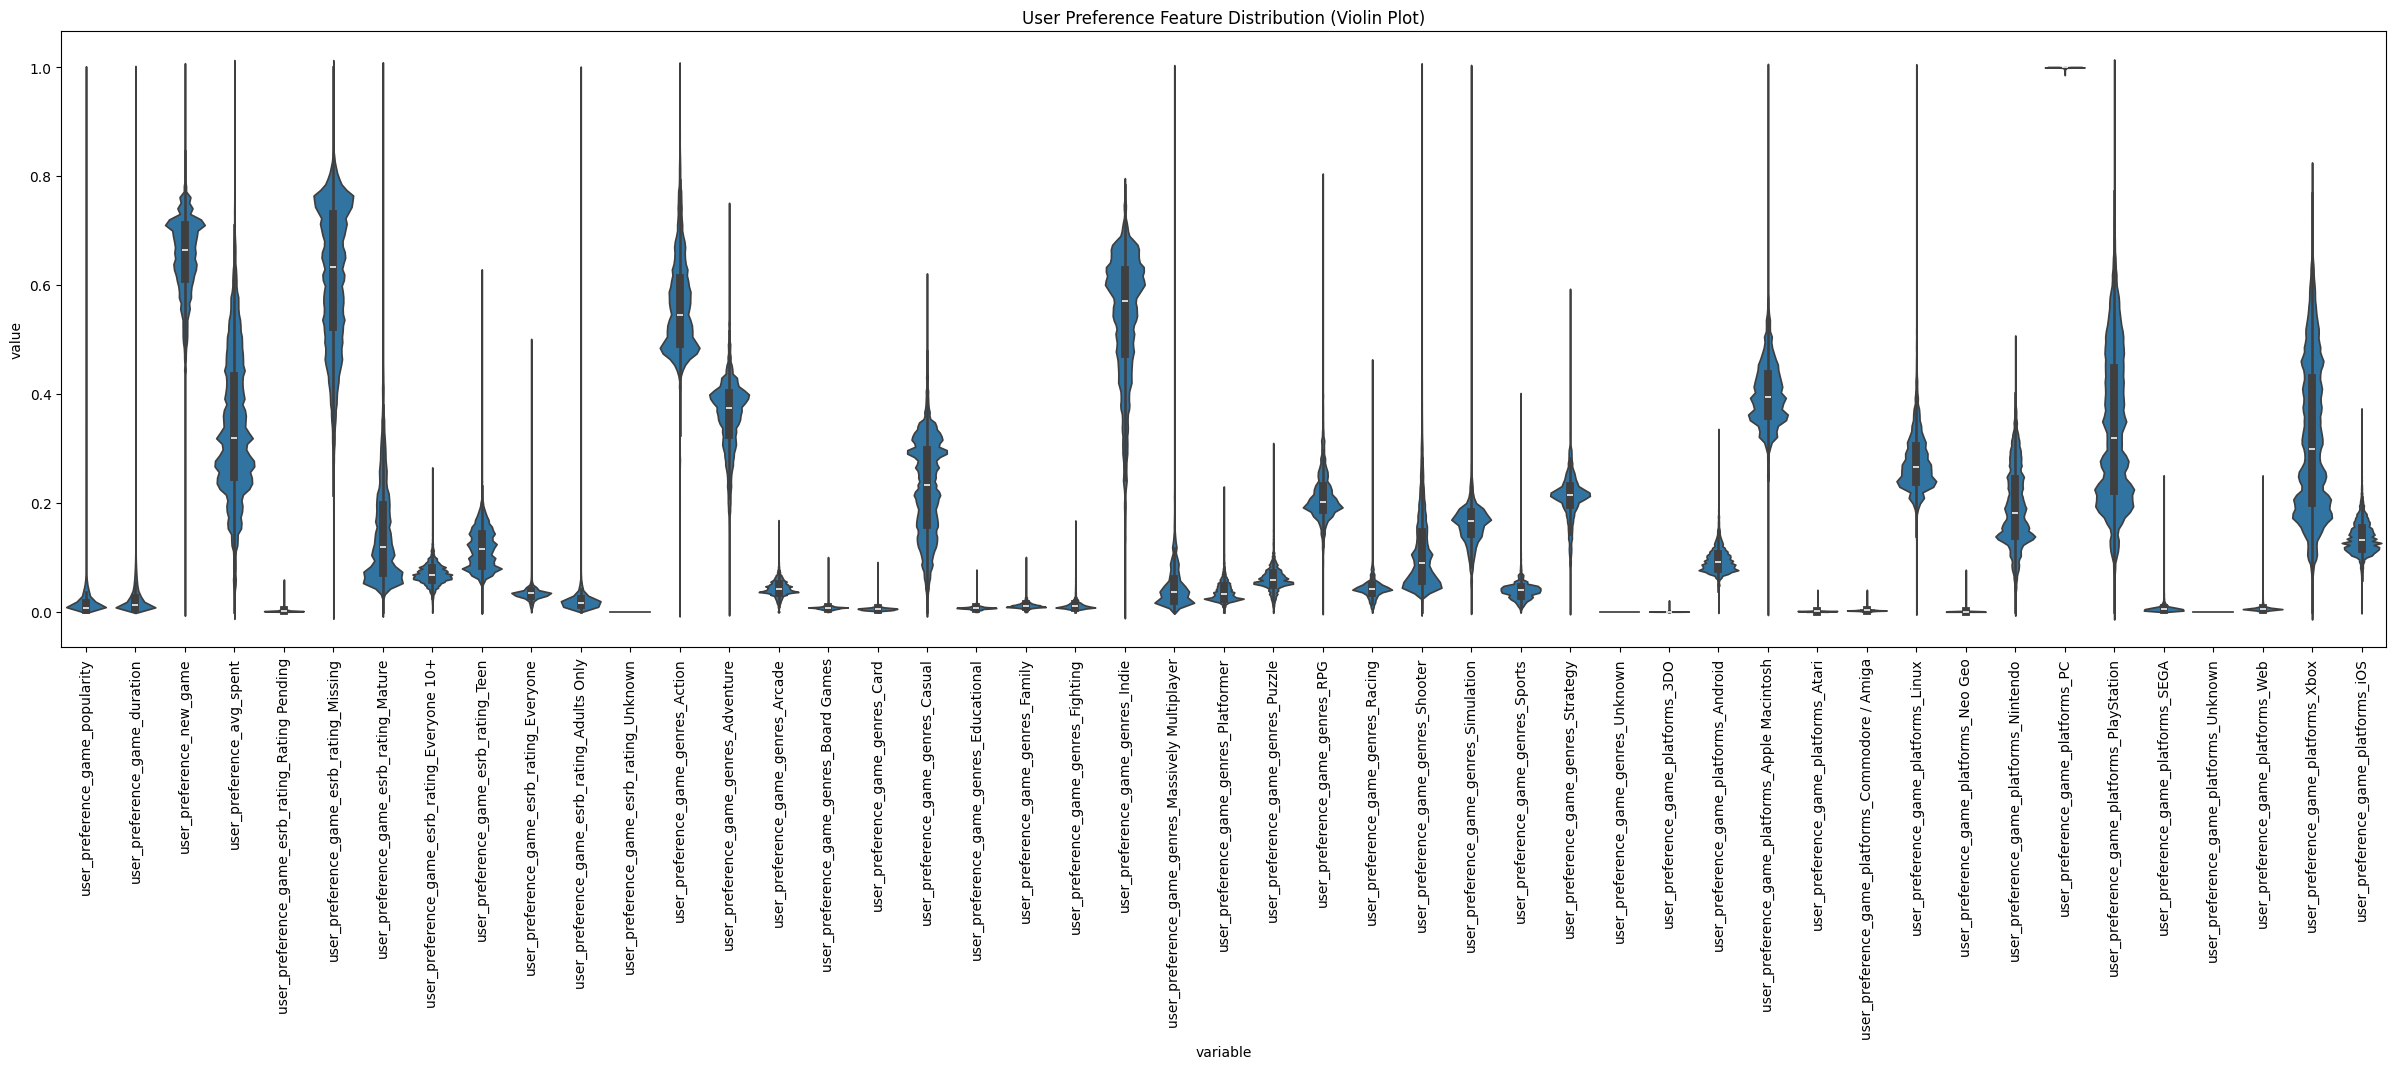

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 8))
user_prefs_melted = train_combined[user_preference_col].melt()  # Convert to long format

sns.violinplot(x='variable', y='value', data=user_prefs_melted, density_norm='width')
plt.xticks(rotation=90)
plt.title("User Preference Feature Distribution (Violin Plot)")
plt.show()

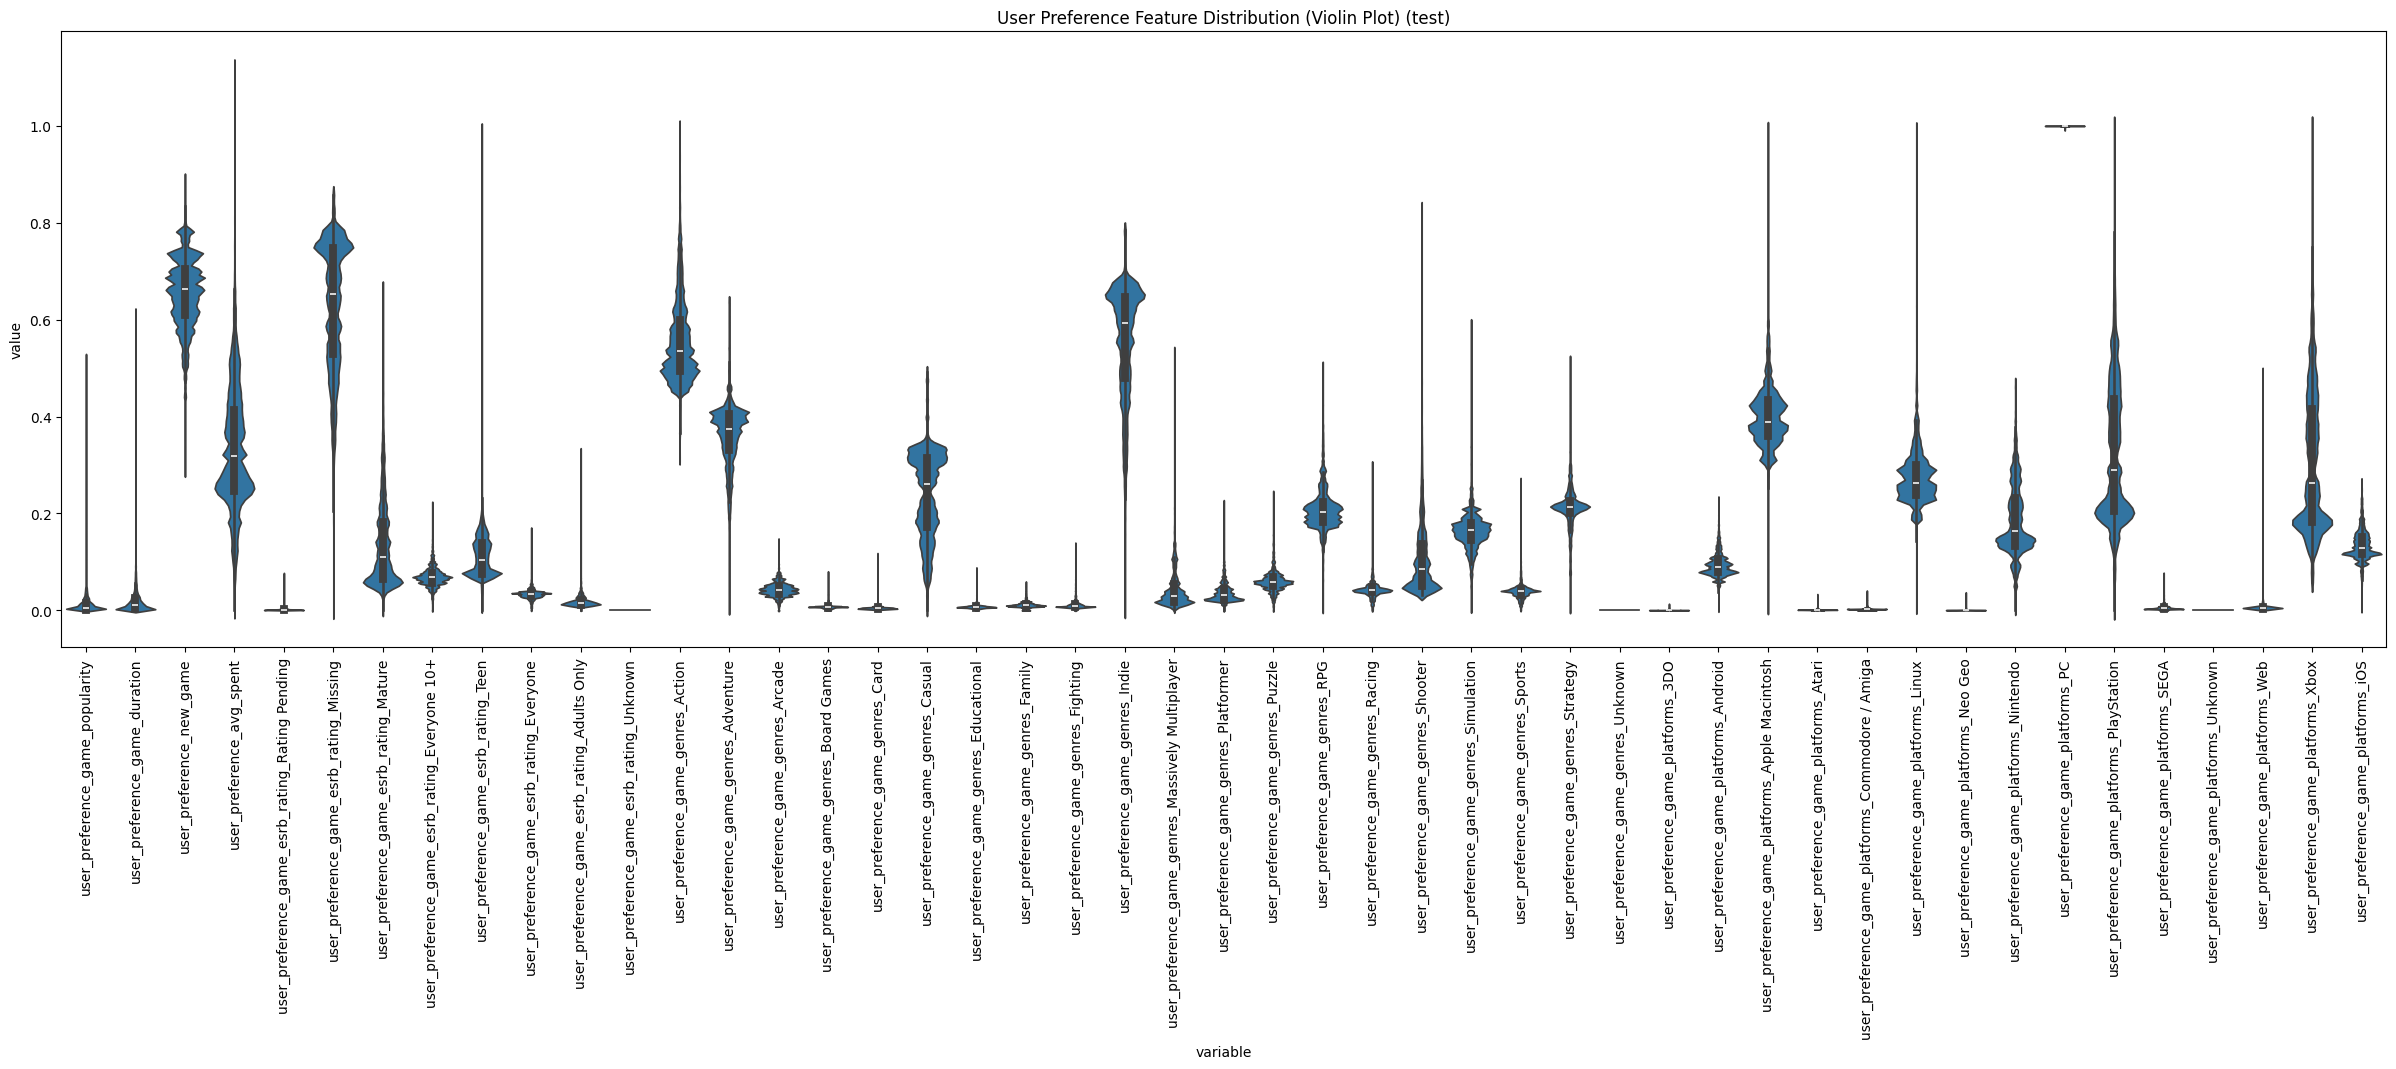

In [16]:
plt.figure(figsize=(30, 8))
user_prefs_melted = test_combined[user_preference_col].melt()  # Convert to long format

sns.violinplot(x='variable', y='value', data=user_prefs_melted, density_norm='width')
plt.xticks(rotation=90)
plt.title("User Preference Feature Distribution (Violin Plot) (test)")
plt.show()

In [24]:
with pd.option_context('display.max_info_columns', len(train_combined.columns)):
    train_combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2643279 entries, 0 to 2643278
Data columns (total 141 columns):
 #    Column                                             Non-Null Count    Dtype  
---   ------                                             --------------    -----  
 0    user_id                                            2643279 non-null  object 
 1    app_id                                             2643279 non-null  int64  
 2    relevance_score                                    2643279 non-null  float64
 3    user_country_code                                  2643279 non-null  object 
 4    user_has_coordinates                               2643279 non-null  bool   
 5    user_latitude                                      2032802 non-null  float64
 6    user_longitude                                     2032802 non-null  float64
 7    user_account_age_months                            2643279 non-null  float64
 8    game_name                                         

In [23]:
joblib.dump(train_combined, r"..\assets\combined\train_feature_engineered.pkl")
joblib.dump(test_combined, r"..\assets\combined\test__feature_engineered.pkl")

['..\\assets\\combined\\test__feature_engineered.pkl']

In [22]:
!pip freeze > ..\requirements.txt